__Implementing a Pitch Control Model__

Pitch control (at a given location on the field) is the probability that a team will gain 
possession if the ball is moved to that location on the field. 

In [1]:
import Metrica_IO as mio
import Metrica_Viz as mviz
import Metrica_Velocities as mvel
import Metrica_PitchControl as mpc
import numpy as np

In [2]:
# set up initial path to data
DATADIR = 'C:/Users/User/Desktop/Datasets/This is the fourth lecture/sample-data-master/sample-data-master/data'
game_id = 2 # let's look at sample match 2

# read in the event data
events = mio.read_event_data(DATADIR,game_id)

# read in tracking data
tracking_home = mio.tracking_data(DATADIR,game_id,'Home')
tracking_away = mio.tracking_data(DATADIR,game_id,'Away')

Reading team: home
Reading team: away


In [3]:
# Convert positions from metrica units to meters (note change in Metrica's coordinate system since the last lesson)
tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)
events = mio.to_metric_coordinates(events)

# reverse direction of play in the second half so that home team is always attacking from right->left
tracking_home,tracking_away,events = mio.to_single_playing_direction(tracking_home,tracking_away,events)

# Calculate player velocities
tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True,filter_='moving_average')
tracking_away = mvel.calc_player_velocities(tracking_away,smoothing=True,filter_='moving_average')

__Pitch control for passes leading up to goal 2__

In [4]:
# get all shots and goals in the match
shots = events[events['Type']=='SHOT']
goals = shots[shots['Subtype'].str.contains('-GOAL')].copy()

goals.head(5)

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
198,Home,SHOT,ON TARGET-GOAL,1,12202,488.08,12212,488.48,Player10,NaN,-47.70,-3.40,-54.06,-2.04
823,Away,SHOT,ON TARGET-GOAL,1,53049,2121.96,53075,2123.00,Player24,NaN,44.52,2.72,54.06,1.36
1118,Home,SHOT,HEAD-ON TARGET-GOAL,2,73983,2959.32,73995,2959.80,Player9,NaN,-47.70,1.36,-54.06,2.04
1671,Away,SHOT,ON TARGET-GOAL,2,115009,4600.36,115024,4600.96,Player20,NaN,40.28,1.36,55.12,2.72
1723,Home,SHOT,ON TARGET-GOAL,2,121027,4841.08,121055,4842.20,Player12,NaN,-30.74,5.44,-54.06,2.72


(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

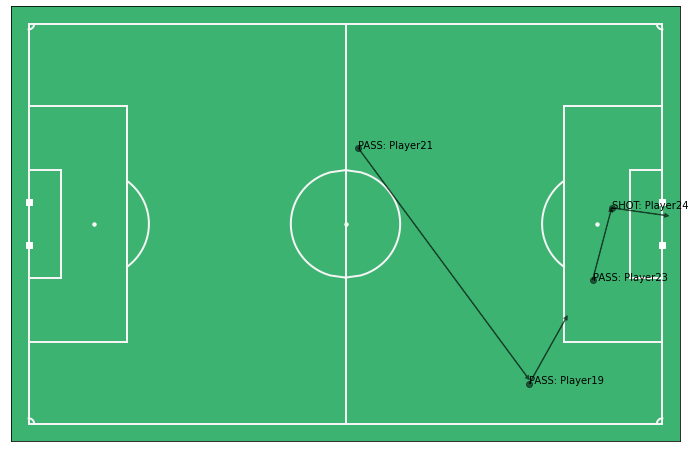

In [17]:
# plot the 3 events leading up to the second goal
mviz.plot_events( events.loc[820:823], color='k', indicators = ['Marker', 'Arrow'], annotate=True )

In [6]:
# first get pitch control model parameters
params = mpc.default_model_params()

params

{'max_player_accel': 7.0,
 'max_player_speed': 5.0,
 'reaction_time': 0.7,
 'tti_sigma': 0.45,
 'kappa_def': 1.0,
 'lambda_att': 4.3,
 'lambda_def': 4.3,
 'lambda_gk': 12.899999999999999,
 'average_ball_speed': 15.0,
 'int_dt': 0.04,
 'max_int_time': 10,
 'model_converge_tol': 0.01,
 'time_to_control_att': 3.3202550055547313,
 'time_to_control_def': 3.3202550055547313}

In [7]:
#find goalkeepers for offside calculation
GK_numbers = [mio.find_goalkeeper(tracking_home),mio.find_goalkeeper(tracking_away)]

__Now let's generate pitch control surface for all 3 events separately__

C:\Users\User\Metrica_Viz.py:141: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot( team[x_columns], team[y_columns], color+'o', MarkerSize=PlayerMarkerSize, alpha=PlayerAlpha ) # plot player positions
C:\Users\User\Metrica_Viz.py:141: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot( team[x_columns], team[y_columns], color+'o', MarkerSize=PlayerMarkerSize, alpha=PlayerAlpha ) # plot player positions
C:\Users\User\Metrica_Viz.py:149: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot( hometeam['ball_x'], hometeam['ball_y'], 'ko', MarkerSize=6, alpha=1.0, LineWidth=0)


(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

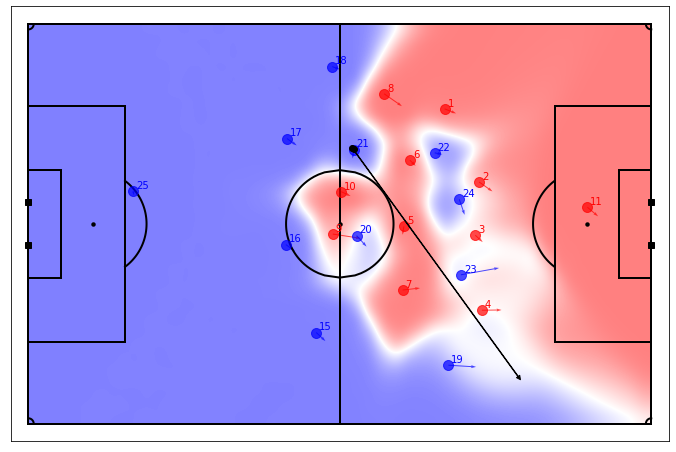

In [21]:
# evaluated pitch control surface for first pass
PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(820, events, tracking_home, tracking_away, params, GK_numbers, field_dimen = (106.,68.,), n_grid_cells_x = 50)
mviz.plot_pitchcontrol_for_event( 820, events,  tracking_home, tracking_away, PPCF, annotate=True )

C:\Users\User\Metrica_Viz.py:141: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot( team[x_columns], team[y_columns], color+'o', MarkerSize=PlayerMarkerSize, alpha=PlayerAlpha ) # plot player positions
C:\Users\User\Metrica_Viz.py:141: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot( team[x_columns], team[y_columns], color+'o', MarkerSize=PlayerMarkerSize, alpha=PlayerAlpha ) # plot player positions
C:\Users\User\Metrica_Viz.py:149: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot( hometeam['ball_x'], hometeam['ball_y'], 'ko', MarkerSize=6, alpha=1.0, LineWidth=0)


(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

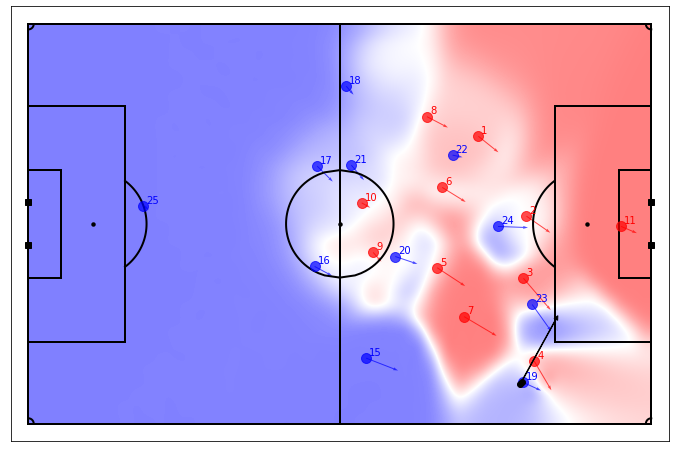

In [9]:
# evaluated pitch control surface for second pass
PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(821, events, tracking_home, tracking_away, params, GK_numbers, field_dimen = (106.,68.,), n_grid_cells_x = 50)
mviz.plot_pitchcontrol_for_event( 821, events,  tracking_home, tracking_away, PPCF, annotate=True )

C:\Users\User\Metrica_Viz.py:141: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot( team[x_columns], team[y_columns], color+'o', MarkerSize=PlayerMarkerSize, alpha=PlayerAlpha ) # plot player positions
C:\Users\User\Metrica_Viz.py:141: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot( team[x_columns], team[y_columns], color+'o', MarkerSize=PlayerMarkerSize, alpha=PlayerAlpha ) # plot player positions
C:\Users\User\Metrica_Viz.py:149: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot( hometeam['ball_x'], hometeam['ball_y'], 'ko', MarkerSize=6, alpha=1.0, LineWidth=0)


(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

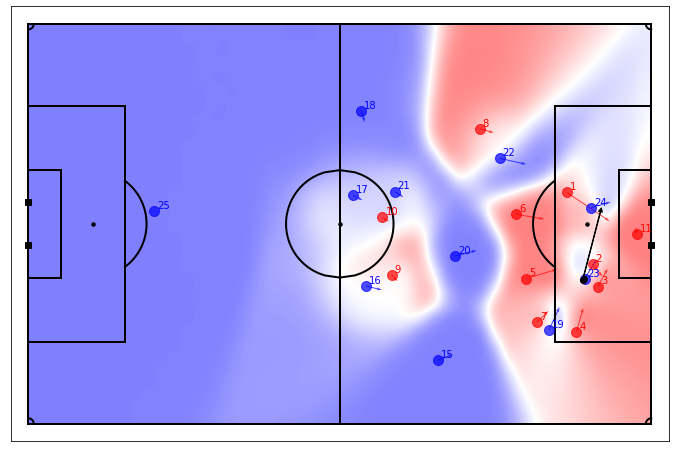

In [10]:
# evaluated pitch control surface for third pass
PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(822, events, tracking_home, tracking_away, params, GK_numbers, field_dimen = (106.,68.,), n_grid_cells_x = 50)
mviz.plot_pitchcontrol_for_event( 822, events,  tracking_home, tracking_away, PPCF, annotate=True )

__Calculate pass probability for every home team succesful pass__

Now let's go through all the completed passes that the home team made in the match and calculate their success probability (the probability those passes would have been succesfull at the moment they have been made)

In [11]:
# get all home passes
home_passes = events[ (events['Type'].isin(['PASS'])) & (events['Team']=='Home') ]

# list for storing pass probablities
pass_success_probability = []

for i,row in home_passes.iterrows():
    pass_start_pos = np.array([row['Start X'],row['Start Y']])
    pass_target_pos = np.array([row['End X'],row['End Y']])
    pass_frame = row['Start Frame']
    
    attacking_players = mpc.initialise_players(tracking_home.loc[pass_frame],'Home',params, GK_numbers[0])
    defending_players = mpc.initialise_players(tracking_away.loc[pass_frame],'Away',params, GK_numbers[1])
    Patt,Pdef = mpc.calculate_pitch_control_at_target(pass_target_pos, attacking_players, defending_players, pass_start_pos, params)

    pass_success_probability.append( (i,Patt) )

Text(0, 0.5, 'Frequency')

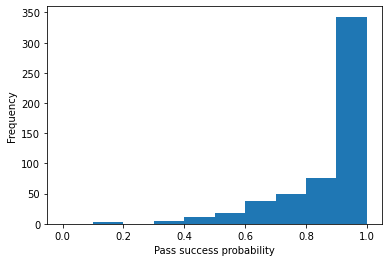

In [12]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.hist( [p[1] for p in pass_success_probability], np.arange(0,1.1,0.1))    
ax.set_xlabel('Pass success probability')
ax.set_ylabel('Frequency')

(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

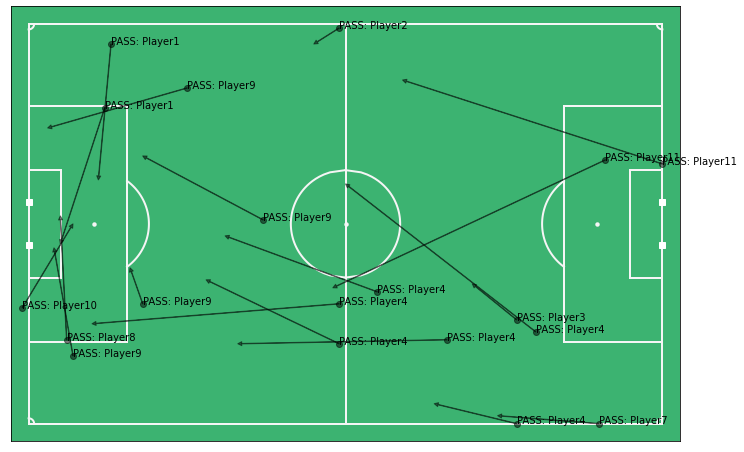

In [13]:
# sort the passes by pitch control probability
pass_success_probability = sorted( pass_success_probability, key = lambda x: x[1] )

# identify the events corresponding to the most risky passes (pitch control < 0.5)
risky_passes = events.loc[ [p[0] for p in pass_success_probability if p[1]<0.5 ] ]

# plot the events
mviz.plot_events( risky_passes, color='k', indicators = ['Marker','Arrow'], annotate=True )

In [14]:
risky_passes.shape

(19, 14)

So they were 19 passes attempted by the home team that were perceived as risky (less than 50% likely to be sucessfull) by our pitch control model.

We can see that the passes that originated in the home team zone half tend to be long passes, 30-40 metres in length, maybe clearences.

On the other hand, the passes on the away team zone half are passes not that long distance but into crowded locations which obviously makes it risky.

In [15]:
# Print events that followed those risky passes
print("Event following a risky (completed) pass")
for p in pass_success_probability[:20]:
    outcome = events.loc[ p[0]+1 ].Type
    print( p[1], outcome )

Event following a risky (completed) pass
0.15958440630526072 BALL LOST
0.164487988405325 CHALLENGE
0.18829182157270935 SHOT
0.3118934257505092 CHALLENGE
0.32875347033439795 SHOT
0.33794938339419445 CHALLENGE
0.36788808390516603 BALL LOST
0.40561251750633315 CHALLENGE
0.4147820093582791 PASS
0.41861866721726027 PASS
0.431819076300889 CHALLENGE
0.44890555499156437 CHALLENGE
0.4610008848168425 CHALLENGE
0.46560735164688416 SHOT
0.46834301223806296 CHALLENGE
0.48894619695173597 CHALLENGE
0.4901175118019355 CHALLENGE
0.492767689646347 SHOT
0.4985384467298248 PASS
0.5040960761022257 PASS


We can see that in most cases the ball was lost. So even though the pass was completed, the team did not retain the posession for very long. Also couple of shots from the penalty area.

How might you use the pitch control model to calculate how much space was created (or territory captured) by an off the ball run? Try to answer, good question cause one of the applications is to beging to quantify the actions of the players off the ball.